In [148]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
import plotly.offline as pyoff
from scipy import stats
import matplotlib as mpl
%matplotlib inline

In [149]:
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from yellowbrick.contrib.scatter import ScatterVisualizer
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score, adjusted_rand_score
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.manifold import TSNE

In [150]:
from google.colab import drive
drive.mount('/content/drive')

customer_tab= pd.read_csv('/content/drive/MyDrive/base_donnée.csv')
segment_rfm =pd.read_csv('https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/table_segmentation.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [151]:
segment_rfm.rename(columns={'Nb_inactive_days':'recency','montant':'monetary'}, inplace=True)

In [152]:
segment_rfm.head(3)

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0


In [153]:
customer_tab.head(3)

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,latitude,longitude,order_id,order_status,order_purchase_timestamp,...,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,catégorie
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP,-20.513713,-47.396644,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16 15:05:35,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,Autres
1,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,barreiras,BA,-12.147031,-44.996092,a4866dfc455353f48014a2b9a86608a2,delivered,2018-01-11 16:47:03,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,Autres
2,97ee81fede5757f1ab031e83d1a59f56,452fab1c62b178922fc011b0eb89c1b9,47800,barreiras,BA,-12.147031,-44.996092,a4866dfc455353f48014a2b9a86608a2,delivered,2018-01-11 16:47:03,...,moveis_escritorio,41.0,1141.0,1.0,8683.0,54.0,64.0,31.0,office_furniture,Autres


In [154]:
customer_tab['order_purchase_timestamp'] = pd.to_datetime(customer_tab['order_purchase_timestamp'])

In [155]:
date_min = customer_tab['order_purchase_timestamp'].min()
date_max = customer_tab['order_purchase_timestamp'].max()

In [156]:
date_min

Timestamp('2016-10-03 09:44:50')

In [157]:
date_max

Timestamp('2018-08-29 15:00:37')

In [158]:
(date_max - date_min).days

695

In [159]:
customer_tab.groupby('customer_unique_id')['order_purchase_timestamp'].count()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Name: order_purchase_timestamp, Length: 92501, dtype: int64

In [160]:
segment_rfm

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,17.63,20.0,0,0,0,0,0,0,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,16.89,13.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92488,fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84,5.0,248.71,27.0,0,0,0,0,0,0,2,0,0
92489,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,19.69,30.0,0,0,0,0,0,0,1,0,0
92490,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,22.56,14.0,0,1,0,0,0,0,0,0,0
92491,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,18.69,11.0,0,0,0,0,0,1,0,0,0


In [161]:
dates = customer_tab[['customer_unique_id','order_purchase_timestamp']].copy()
dates.columns = ['customer_unique_id', 'Date_de_commande']

In [162]:
dates

,customer_unique_id,Date_de_commande
0,861eff4711a542e4b93843c6dd7febb0,2017-05-16 15:05:35
1,452fab1c62b178922fc011b0eb89c1b9,2018-01-11 16:47:03
2,452fab1c62b178922fc011b0eb89c1b9,2018-01-11 16:47:03
3,613259d64ba972e49dc25b019b7918c3,2017-12-07 16:41:50
4,aaad33c5051196b5e73c7d65b9072e1d,2018-03-13 20:11:20
...,...,...
114552,20120882a566b99eb67c104dc05d896f,2017-07-09 15:17:43
114553,7c0b4f7719caf8b29a4c8dbd5a1446c9,2018-06-11 16:10:21
114554,640ac18151727c99757e30b92253dbc0,2018-04-29 17:40:51
114555,48f2f72862e37acc97f50b4484ee2af4,2017-10-17 21:50:00


In [163]:
segment_rfm

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,17.63,20.0,0,0,0,0,0,0,0,0,1
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,16.89,13.0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92488,fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84,5.0,248.71,27.0,0,0,0,0,0,0,2,0,0
92489,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,19.69,30.0,0,0,0,0,0,0,1,0,0
92490,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,22.56,14.0,0,1,0,0,0,0,0,0,0
92491,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,18.69,11.0,0,0,0,0,0,1,0,0,0


In [164]:
df = segment_rfm.merge(dates, on = 'customer_unique_id', how = 'inner')

In [165]:
df.shape

(114549, 17)

In [166]:
df

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique,Date_de_commande
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,17.63,20.0,0,0,0,0,0,0,0,0,1,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,16.89,13.0,0,0,0,0,0,0,0,0,1,2017-11-14 19:45:42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114544,fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84,5.0,248.71,27.0,0,0,0,0,0,0,2,0,0,2017-06-08 21:00:36
114545,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,19.69,30.0,0,0,0,0,0,0,1,0,0,2017-12-10 20:07:56
114546,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,22.56,14.0,0,1,0,0,0,0,0,0,0,2017-02-07 15:49:16
114547,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,18.69,11.0,0,0,0,0,0,1,0,0,0,2018-05-02 15:17:41


In [167]:
date_min = df['Date_de_commande'].min()
date_max = df['Date_de_commande'].max()

In [168]:
df['Nb_jour_du_programme'] = (df['Date_de_commande'] - date_min).dt.days 

In [169]:
df

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique,Date_de_commande,Nb_jour_du_programme
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0,2018-05-10 10:56:27,584
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0,2018-05-07 11:11:27,581
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0,2017-03-10 21:05:03,158
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,17.63,20.0,0,0,0,0,0,0,0,0,1,2017-10-12 20:29:41,374
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,16.89,13.0,0,0,0,0,0,0,0,0,1,2017-11-14 19:45:42,407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114544,fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84,5.0,248.71,27.0,0,0,0,0,0,0,2,0,0,2017-06-08 21:00:36,248
114545,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,19.69,30.0,0,0,0,0,0,0,1,0,0,2017-12-10 20:07:56,433
114546,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,22.56,14.0,0,1,0,0,0,0,0,0,0,2017-02-07 15:49:16,127
114547,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,18.69,11.0,0,0,0,0,0,1,0,0,0,2018-05-02 15:17:41,576


In [170]:
df['group_jours'] = df['Nb_jour_du_programme'] // 15

In [171]:
df

,customer_unique_id,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,Alimentation et Boissons,Auto et Moto,Autres,Livres et Médias,Maison et Jardin,Mode,Santé et Beauté,Sports et Loisirs,Électronique,Date_de_commande,Nb_jour_du_programme,group_jours
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,5.0,12.00,6.0,0,0,0,0,1,0,0,0,0,2018-05-10 10:56:27,584,38
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,4.0,8.29,3.0,0,0,0,0,0,0,1,0,0,2018-05-07 11:11:27,581,38
2,0000f46a3911fa3c0805444483337064,536,1,86.22,3.0,17.22,25.0,0,0,0,0,0,0,0,0,0,2017-03-10 21:05:03,158,10
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,4.0,17.63,20.0,0,0,0,0,0,0,0,0,1,2017-10-12 20:29:41,374,24
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,5.0,16.89,13.0,0,0,0,0,0,0,0,0,1,2017-11-14 19:45:42,407,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114544,fffcf5a5ff07b0908bd4e2dbc735a684,446,2,4134.84,5.0,248.71,27.0,0,0,0,0,0,0,2,0,0,2017-06-08 21:00:36,248,16
114545,fffea47cd6d3cc0a88bd621562a9d061,261,1,84.58,4.0,19.69,30.0,0,0,0,0,0,0,1,0,0,2017-12-10 20:07:56,433,28
114546,ffff371b4d645b6ecea244b27531430a,567,1,112.46,5.0,22.56,14.0,0,1,0,0,0,0,0,0,0,2017-02-07 15:49:16,127,8
114547,ffff5962728ec6157033ef9805bacc48,118,1,133.69,5.0,18.69,11.0,0,0,0,0,0,1,0,0,0,2018-05-02 15:17:41,576,38


In [172]:
new_df = df.copy()
new_df = new_df.drop(['customer_unique_id','Date_de_commande','Nb_jour_du_programme'], axis = 1)

In [173]:
new_df.groupby('group_jours').agg({
    'recency' : 'median',
    'frequency' : 'median',
    'monetary': 'median', 
    'note_com' : 'median',
    'frais_livraison' : 'median',
    'temps_moyen_livraison' : 'median',
    'group_jours' : 'count'    
})

,recency,frequency,monetary,note_com,frais_livraison,temps_moyen_livraison,group_jours
group_jours,,,,,,,
0,691.0,1.0,149.465,5.0,16.330,17.0,330
5,601.0,2.0,39.240,5.0,8.720,5.0,1
6,594.0,1.0,110.720,5.0,15.400,11.0,133
7,580.0,1.0,166.140,5.0,16.110,10.0,766
8,567.0,1.0,130.295,5.0,16.580,9.0,1210
9,551.0,1.0,128.260,5.0,16.050,12.0,957
10,537.0,1.0,132.960,5.0,16.050,10.0,1506
11,522.0,1.0,123.250,5.0,16.050,10.0,1427
12,508.0,1.0,124.010,5.0,16.050,10.0,1229


In [174]:
scaler = StandardScaler()

In [175]:
customer_tab.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114557 entries, 0 to 114556
Data columns (total 40 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    114557 non-null  object        
 1   customer_unique_id             114557 non-null  object        
 2   customer_zip_code_prefix       114557 non-null  int64         
 3   customer_city                  114557 non-null  object        
 4   customer_state                 114557 non-null  object        
 5   latitude                       114557 non-null  float64       
 6   longitude                      114557 non-null  float64       
 7   order_id                       114557 non-null  object        
 8   order_status                   114557 non-null  object        
 9   order_purchase_timestamp       114557 non-null  datetime64[ns]
 10  order_approved_at              114542 non-null  object        
 11  

In [176]:
customers = pd.read_csv("https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_customers_dataset.csv")[
    ["customer_id", "customer_unique_id"]
].copy()

orders = pd.read_csv(
    "https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
)[["order_id", "customer_id", "order_purchase_timestamp"]].copy()

order_items = (
    pd.read_csv("https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_order_items_dataset.csv")[
        ["order_id", "price", "freight_value"]
    ]
    .groupby("order_id")
    .agg("sum")
    .reset_index()
    .copy()
)

order_reviews = pd.read_csv(
    "https://raw.githubusercontent.com/bachir151/Projet-openclassrooms/master/P4/data/olist_order_reviews_dataset.csv",
    parse_dates=[
        "review_creation_date",
        "review_answer_timestamp",
    ],
)[["review_creation_date", "review_score", "order_id"]]

start_date = orders["order_purchase_timestamp"].min()
end_date = orders["order_purchase_timestamp"].max()

In [177]:
def get_customers(group_days, customers_ids=[]):
    
    end_date = start_date + group_days * timedelta(days = 15)

    s_orders_items = order_items.copy()
    s_orders_items["total_value"] = (
        s_orders_items["price"] + s_orders_items["freight_value"]
    )

    s_orders = orders.copy()

    orders_period = (
        s_orders.order_purchase_timestamp >= start_date.strftime("%Y-%m-%d")
    ) & (s_orders.order_purchase_timestamp <= end_date.strftime("%Y-%m-%d"))
    s_orders = s_orders.loc[orders_period, :]
    s_orders = s_orders.merge(
        s_orders_items[["order_id", "total_value"]], on="order_id"
    )

    order_reviews_period = (
        order_reviews.review_creation_date >= start_date.strftime("%Y-%m-%d")
    ) & (order_reviews.review_creation_date <= end_date.strftime("%Y-%m-%d"))
    s_order_reviews = order_reviews.loc[order_reviews_period, :]
    
    
    
    
    s_orders_items = order_items.copy()
    s_orders_items["total_value"] = (
        s_orders_items["price"] + s_orders_items["freight_value"]
    )

    s_orders = orders.copy()

    orders_period = (s_orders.order_purchase_timestamp >= start_date.strftime("%Y-%m-%d")) & \
                    (s_orders.order_purchase_timestamp <= end_date.strftime("%Y-%m-%d"))
    
    s_orders = s_orders.loc[orders_period, :]
    s_orders = s_orders.merge(
        s_orders_items[["order_id", "total_value"]], on="order_id"
    )

    order_reviews_period = (
        order_reviews.review_creation_date >= start_date.strftime("%Y-%m-%d")
    ) & (order_reviews.review_creation_date <= end_date.strftime("%Y-%m-%d"))
    s_order_reviews = order_reviews.loc[order_reviews_period, :]

    s_customers = (
        customers.merge(s_orders, on="customer_id")
        .merge(s_order_reviews, on="order_id")
        .groupby("customer_unique_id")
        .agg(
            first_order = pd.NamedAgg(column = "order_purchase_timestamp", aggfunc = "min"),
            last_order = pd.NamedAgg(column = "order_purchase_timestamp", aggfunc = "max"),
            frequence = pd.NamedAgg(column = "order_id", aggfunc = "nunique"),
            monnaie = pd.NamedAgg(column = "total_value", aggfunc = "sum"),
            review_score = pd.NamedAgg(column = "review_score", aggfunc = "mean"),
        )
        .reset_index()
    )

    s_customers["recence"] = (
        s_customers["last_order"] - s_customers["first_order"]
    ).dt.days + 1
    s_customers = s_customers.set_index("customer_unique_id")

    s_customers = s_customers[["recence", "frequence", "monnaie", "review_score"]]

    if customers_ids:
        return s_customers.loc[customers_ids]
    return s_customers


def prepare_data_for_model(customers: pd.DataFrame):
    scaler = StandardScaler()

    return scaler.fit_transform(customers)


def get_trained_model(group_days, customers_ids=[], verbose=False):
    customers = get_customers(group_days, customers_ids=customers_ids)

    if verbose:
        print(
            "Entrainement du model sur {0} Clients apres {1} jours soit le groupe {2}".format(
                str(customers.shape[0]), str(group_days*15), str(group_days)
            )
        )

    scaled_customers = prepare_data_for_model(customers)

    return KMeans(n_clusters=6, random_state=0).fit(scaled_customers)


def predict_group_labels(trained_model, group_days, model_name, verbose=False):
    customers = get_customers(group_days)

    if verbose:
        print(
            "Prediction  du model a partir des {0} Clients labelisés du groupe original par le model {1}".format(
                str(customers.shape[0]), model_name
            )
        )

    model_labels = trained_model.labels_

    return model_labels[: customers.shape[0]]

In [178]:
def get_ari_score(group_days_of_training, verbose=False):
    customers_ids = get_customers(group_days_of_training).index.to_list()
    m1 = get_trained_model(group_days_of_training)
    true_labels = m1.labels_

    ari_scores = []
    
    for model in range(1,(end_date - start_date).days // 15 + 1 - group_days_of_training):
        group_days = model + group_days_of_training

        # Train the model with the new data
        new_model = get_trained_model(group_days, customers_ids, verbose)

        # Get the predicted labels predicted by the new model
        predicted_labels = predict_group_labels(
            new_model, group_days_of_training, f"Model {group_days}", verbose
        )

        ari_scores.append(
            {
                "Group_jours": model,
                "ari_score": adjusted_rand_score(true_labels, predicted_labels),
            }
        )

    return ari_scores

In [179]:
%%time
import warnings
warnings.simplefilter("ignore")

ari_scores = get_ari_score(26, verbose=True)

Entrainement du model sur 24482 Clients apres 405 jours soit le groupe 27
Prediction  du model a partir des 24482 Clients labelisés du groupe original par le model Model 27
Entrainement du model sur 24482 Clients apres 420 jours soit le groupe 28
Prediction  du model a partir des 24482 Clients labelisés du groupe original par le model Model 28
Entrainement du model sur 24482 Clients apres 435 jours soit le groupe 29
Prediction  du model a partir des 24482 Clients labelisés du groupe original par le model Model 29
Entrainement du model sur 24482 Clients apres 450 jours soit le groupe 30
Prediction  du model a partir des 24482 Clients labelisés du groupe original par le model Model 30
Entrainement du model sur 24482 Clients apres 465 jours soit le groupe 31
Prediction  du model a partir des 24482 Clients labelisés du groupe original par le model Model 31
Entrainement du model sur 24482 Clients apres 480 jours soit le groupe 32
Prediction  du model a partir des 24482 Clients labelisés du 

CPU times: user 38.3 ms, sys: 8.07 ms, total: 46.4 ms
Wall time: 40.2 ms


<AxesSubplot:title={'center':'Evolution du ARI Score par quizaine de jours'}, xlabel='Group_jours'>

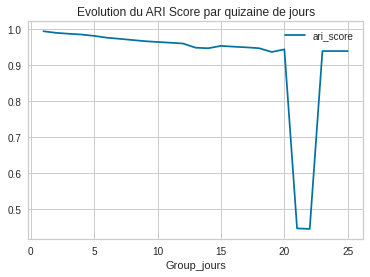

In [180]:
%%time
pd.DataFrame(ari_scores).plot(title="Evolution du ARI Score par quizaine de jours",
                              x="Group_jours",
                              y="ari_score");

In [181]:
ari_scores

[{'Group_jours': 1, 'ari_score': 0.9935438490049174},
 {'Group_jours': 2, 'ari_score': 0.9890639506602761},
 {'Group_jours': 3, 'ari_score': 0.9865600345297139},
 {'Group_jours': 4, 'ari_score': 0.9844184203927092},
 {'Group_jours': 5, 'ari_score': 0.9806117494762909},
 {'Group_jours': 6, 'ari_score': 0.9756865743104912},
 {'Group_jours': 7, 'ari_score': 0.9725050971813283},
 {'Group_jours': 8, 'ari_score': 0.9692069482208245},
 {'Group_jours': 9, 'ari_score': 0.9659408914460449},
 {'Group_jours': 10, 'ari_score': 0.963662521398361},
 {'Group_jours': 11, 'ari_score': 0.9616388887312954},
 {'Group_jours': 12, 'ari_score': 0.9594305184397067},
 {'Group_jours': 13, 'ari_score': 0.9478167909471362},
 {'Group_jours': 14, 'ari_score': 0.9462133433286424},
 {'Group_jours': 15, 'ari_score': 0.9528314326653271},
 {'Group_jours': 16, 'ari_score': 0.950647889764},
 {'Group_jours': 17, 'ari_score': 0.9487757702439392},
 {'Group_jours': 18, 'ari_score': 0.9463683243715807},
 {'Group_jours': 19, 'ar

On peut ainsi programmer une mise à jour de notre programme après 7 mois soit le groupe 